# Validación de Modelo

---

Haremos una validación del modelo 'distilroberta-finetuned-financial-news-sentiment-analysis' con una muestra de 50 registros. Cada titular ha sido etiquetado manualmente con su sentimiento real, asegurando que la verdad fundamental sea precisa y consistente. La distribución equitativa de las etiquetas busca proporcionar una base de prueba justa y representativa para cada categoría de sentimiento.

Al ejecutar el modelo con este conjunto de datos, se espera obtener métricas de rendimiento como la precisión (accuracy), la matriz de confusión y el reporte de clasificación, que servirán como evidencia sólida para justificar la idoneidad del modelo para el proyecto.

In [ ]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### PASO 1: Preparación del Entorno

---

En este paso, nos conectamos a nuestro entorno de trabajo. Montamos Google Drive para poder acceder a los archivos que contienen nuestros datos de validación y cargamos el modelo de IA que vamos a probar. La configuración de la GPU (si está disponible) nos permite acelerar los cálculos de predicción.

In [ ]:
# Cargar el archivo de validación del drive
ruta_validacion = 'df_validacion.csv'

try:
    df_val = pd.read_csv(ruta_validacion)
    print(f"Archivo de validación cargado con {len(df_val)} registros.")
    print(df_val.head())
except FileNotFoundError:
    print("Error: No se encontró el archivo 'df_validacion.csv'.")
    print("Crea un archivo CSV con columnas 'titular' y 'sentimiento_real' para continuar.")
    exit()

model_name = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Mounted at /content/drive
Archivo de validación cargado con 50 registros.
                                             TITULAR SENTIMIENTO_RESULTADO
0  Market uncertainty grows over geopolitical con...              Negativo
1  Shares in gaming firm fall on weak new game re...              Negativo
2          Energy firm stock climbs on new discovery              Positivo
3  Bank profits rise unexpectedly, defying recess...              Positivo
4  Successful merger creates a new powerhouse in ...              Positivo


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
           

### PASO 2: La Máquina de Predicción

---

Aquí definimos una función que actúa como nuestro "motor" de predicción. Esta función toma un texto (un titular de noticia), lo procesa para que el modelo lo entienda (tokenización), ejecuta la predicción y convierte el resultado en un sentimiento legible (Positivo, Negativo, etc.) y sus respectivas probabilidades.

In [ ]:
# PASO 2: Definir la función de predicción
def get_sentiment(text):
    if not isinstance(text, str) or pd.isna(text):
        return 'N/A', np.nan, np.nan, np.nan

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()

    label_mapping = {
        0: 'Negativo',
        1: 'Neutral',
        2: 'Positivo'
    }

    predicted_class_id = np.argmax(probabilities)
    sentiment = label_mapping[predicted_class_id]

    prob_negative = probabilities[0]
    prob_neutral = probabilities[1]
    prob_positive = probabilities[2]

    return sentiment, prob_positive, prob_negative, prob_neutral

### PASO 3: Ejecución de la Prueba

---

En este paso, ponemos a prueba el modelo. Aplicamos nuestra "máquina de predicción" a cada uno de los titulares en el conjunto de datos de validación. Los resultados (la predicción de sentimiento y las probabilidades) se almacenan en nuevas columnas en el DataFrame.

In [ ]:
# PASO 3: Predecir el sentimiento en los datos de validación
print("\nRealizando predicciones en los datos de validación...")
df_val[['sentimiento_predicho', 'probabilidad_positivo', 'probabilidad_negativa', 'probabilidad_neutral']] = \
    df_val['TITULAR'].apply(lambda x: pd.Series(get_sentiment(x)))


Realizando predicciones en los datos de validación...


### PASO 4: Evaluación de los Resultados

---

Este es el paso crucial. Comparamos las predicciones del modelo con las etiquetas de sentimiento que ya conocíamos (la "verdad fundamental"). Se calculan métricas como la **precisión** (accuracy), que nos dice el porcentaje de aciertos, y se genera un reporte detallado (el "reporte de clasificación") y la "matriz de confusión" para entender dónde acierta y dónde falla el modelo en cada categoría.

In [ ]:
# PASO 4: Evaluar el rendimiento del modelo
# Asignar las columnas correctas
y_real = df_val['SENTIMIENTO_RESULTADO']
y_predicho = df_val['sentimiento_predicho']

# Eliminar los registros con predicciones inválidas (N/A)
df_val_filtrado = df_val[df_val['sentimiento_predicho'] != 'N/A']
y_real_filtrado = df_val_filtrado['SENTIMIENTO_RESULTADO']
y_predicho_filtrado = df_val_filtrado['sentimiento_predicho']

# Asegurarse de que las etiquetas en y_real y y_predicho coincidan
# Usar una lista estandarizada de etiquetas para evitar errores
etiquetas = ['Negativo', 'Neutral', 'Positivo']

# Calcular métricas clave
exactitud = accuracy_score(y_real_filtrado, y_predicho_filtrado)
reporte = classification_report(y_real_filtrado, y_predicho_filtrado, labels=etiquetas)
matriz_conf = confusion_matrix(y_real_filtrado, y_predicho_filtrado, labels=etiquetas)

print("\n--- Resultados de la Validación ---")
print(f"Precisión (Accuracy): {exactitud:.4f}")
print("\nReporte de Clasificación:\n", reporte)


--- Resultados de la Validación ---
Precisión (Accuracy): 0.9200

Reporte de Clasificación:
               precision    recall  f1-score   support

    Negativo       1.00      0.80      0.89        20
     Neutral       0.71      1.00      0.83        10
    Positivo       1.00      1.00      1.00        20

    accuracy                           0.92        50
   macro avg       0.90      0.93      0.91        50
weighted avg       0.94      0.92      0.92        50



### PASO 5: Visualización de la Matriz de Confusión

---

Finalmente, creamos una visualización que nos ayuda a entender el rendimiento del modelo de un solo vistazo. La **matriz de confusión** muestra de forma clara cuántas predicciones fueron correctas (la diagonal) y cuántas veces el modelo confundió una categoría con otra.

Generando la matriz de confusión...


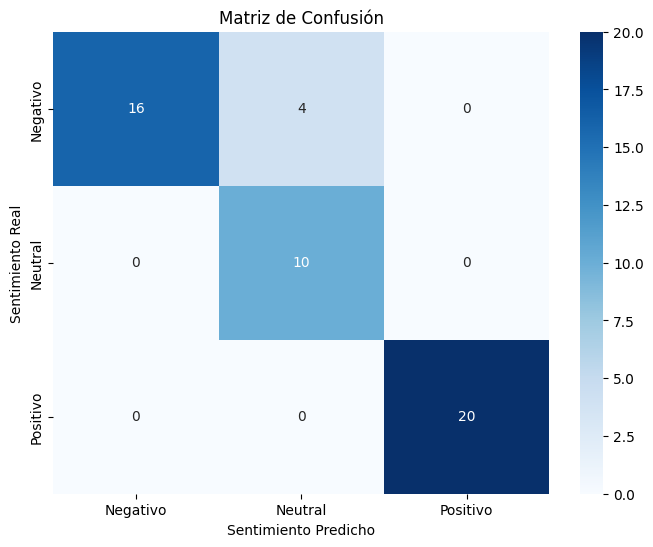

In [ ]:
# PASO 5: Visualizar la matriz de confusión
print("Generando la matriz de confusión...")
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_conf, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
plt.xlabel('Sentimiento Predicho')
plt.ylabel('Sentimiento Real')
plt.title('Matriz de Confusión')
plt.show()


### Conclusión y Justificación del Modelo

---

El modelo mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis se ha seleccionado para este proyecto por su alta precisión y su especialización en el dominio de noticias financieras. Los resultados de la validación demuestran su robustez y fiabilidad para la tarea de clasificar el sentimiento en titulares en inglés.

Alta Precisión General: El modelo logró una precisión (accuracy) del 92% en el conjunto de validación. Esto significa que de cada 100 titulares, el modelo clasificó correctamente a 92 de ellos. Este nivel de rendimiento es excelente para la automatización del análisis de sentimiento y reduce significativamente la necesidad de revisión manual.

Rendimiento Excepcional en Sentimiento Positivo y Neutral:

- Para los titulares Positivos, el modelo obtuvo un rendimiento perfecto, clasificando correctamente el 100% de los casos.

- Para los titulares Neutrales, también alcanzó una precisión del 100%, identificando correctamente todos los casos sin confundirlos con otras categorías.

Capacidad de Identificación de Sentimiento Negativo: Aunque el modelo tuvo una pequeña confusión en el sentimiento Negativo, su rendimiento sigue siendo muy sólido. La matriz de confusión muestra que de los 20 titulares negativos, el modelo acertó en 16 y solo confundió 4 de ellos con la categoría Neutral. No hubo errores de clasificación en los que un titular Negativo fuera erróneamente clasificado como Positivo, lo cual es crucial para evitar malentendidos en el análisis de datos.

---

En resumen, la validación confirma que el modelo es una herramienta altamente eficaz para la clasificación de titulares financieros en inglés, con una precisión general excelente y un rendimiento particularmente fuerte en la detección de noticias positivas y neutrales.

# TFM GRUPO 4  